日本語フォントが利用可能です
CSVファイルの読み込みに成功しました。行数: 317
データのサイズ: (317, 166)
カラム名の一部: Index(['InspectionDateAndId', 'direction_change_frequency',
       'window_15sec_direction_changes_mean',
       'window_15sec_direction_changes_std', 'high_freq_power', 'freq',
       'power_spectrum', 'target', 'Age', 'LatencyMean'],
      dtype='object') ...
配列データを含むカラム (2個): ['freq', 'power_spectrum']
配列データを含むカラムを削除しました。残りのカラム数: 164
前処理後のデータサイズ: (317, 163)
特徴量の数: 163, ターゲットカラムなし
NaN値の合計: 70
NaN値を平均値で置換しました
特徴量の標準化が完了しました
UMAPによる2次元への次元削減を実行中...
UMAP次元削減が完了しました


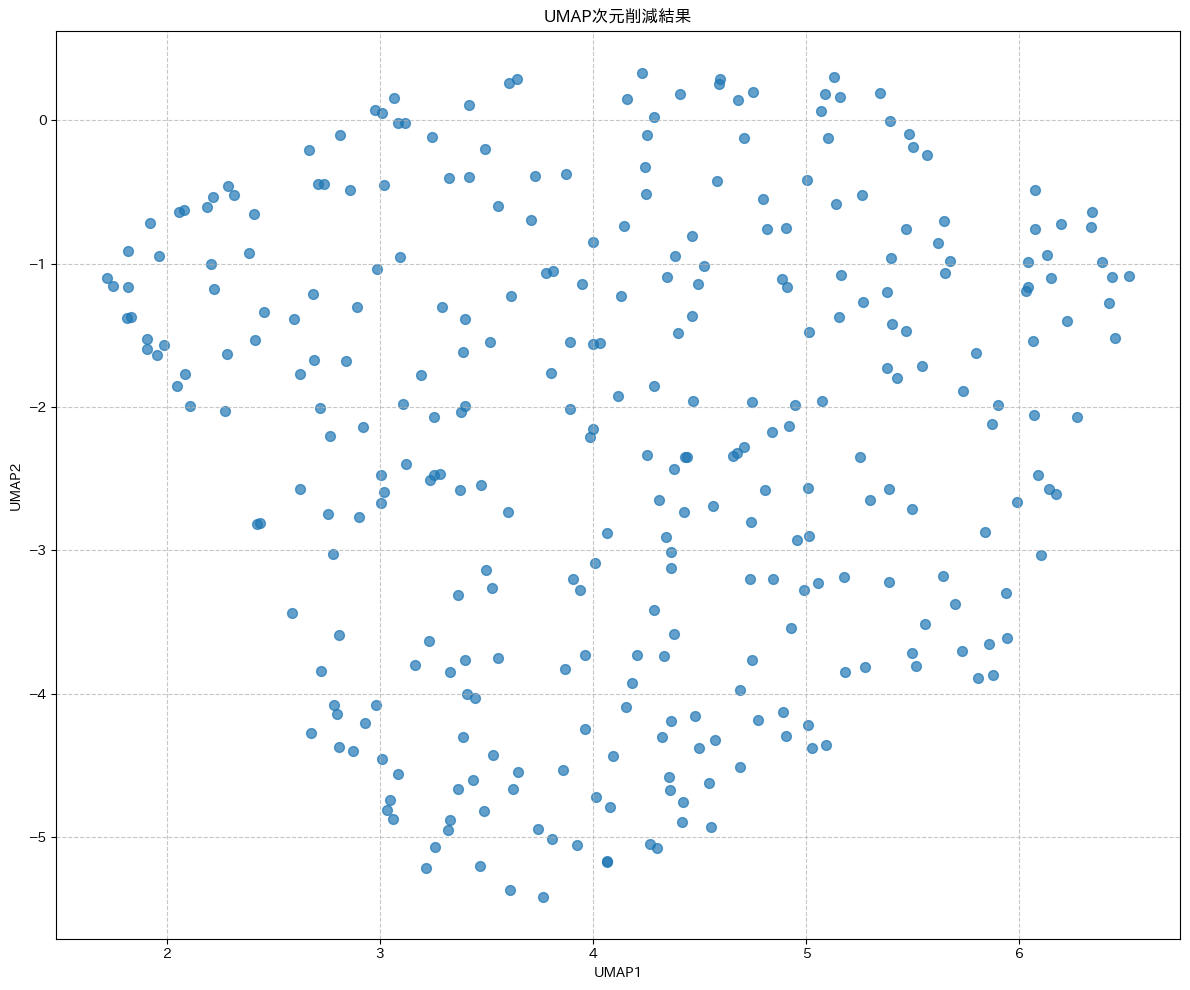

UMAP次元と元の特徴量との相関を計算中...
UMAP次元との相関が高い上位80個の特徴量:
1. SaccadeWidthMaxMeanDistanceFlg2: 0.5413
2. SaccadeWidthMaxMean: 0.5221
3. GainMeanIsError0: 0.5220
4. ResponseTimeMeanDistanceFlg2: 0.5180
5. GainMeanDistanceFlg2: 0.5145
6. SaccadeWidthSumStd: 0.5079
7. ResponseTimeMeanIsError0: 0.4980
8. SaccadeWidthSumMeanDistanceFlg2: 0.4897
9. SaccadeWidthMaxMeanIsError0: 0.4869
10. SaccadeWidthSumMaxIsError1: 0.4781


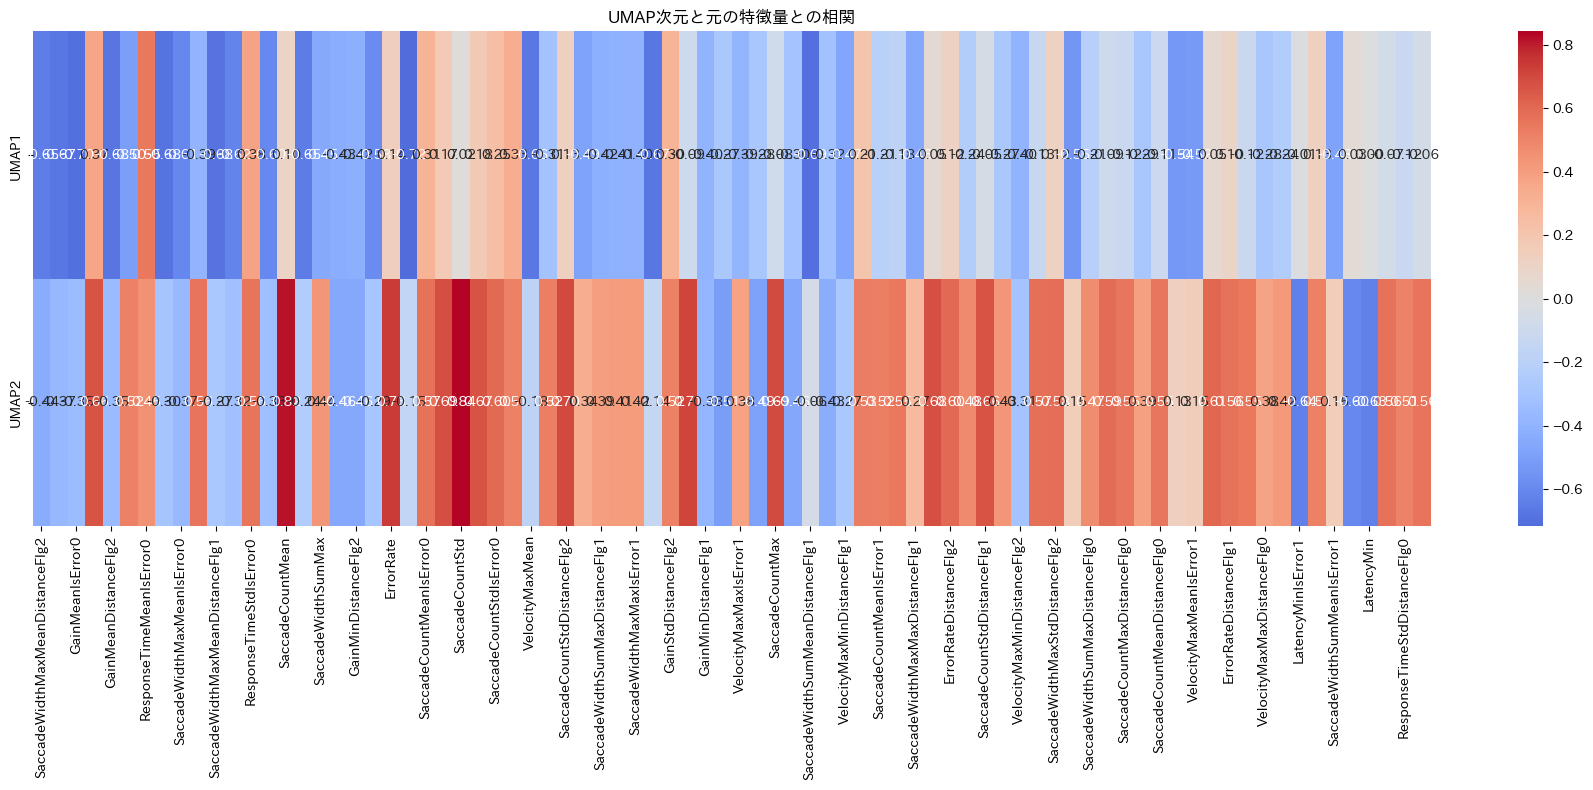

上位5個の特徴量で色分けした散布図を作成中...


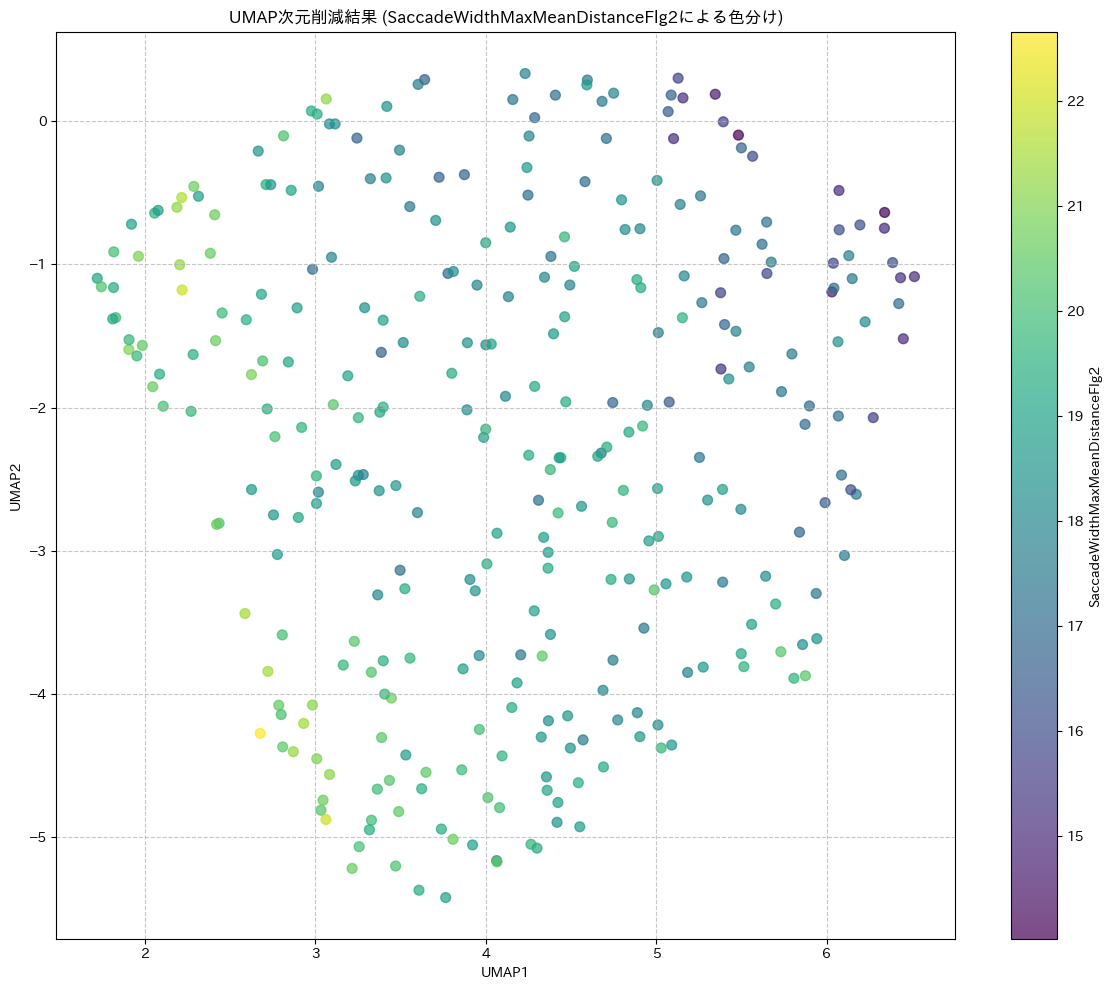

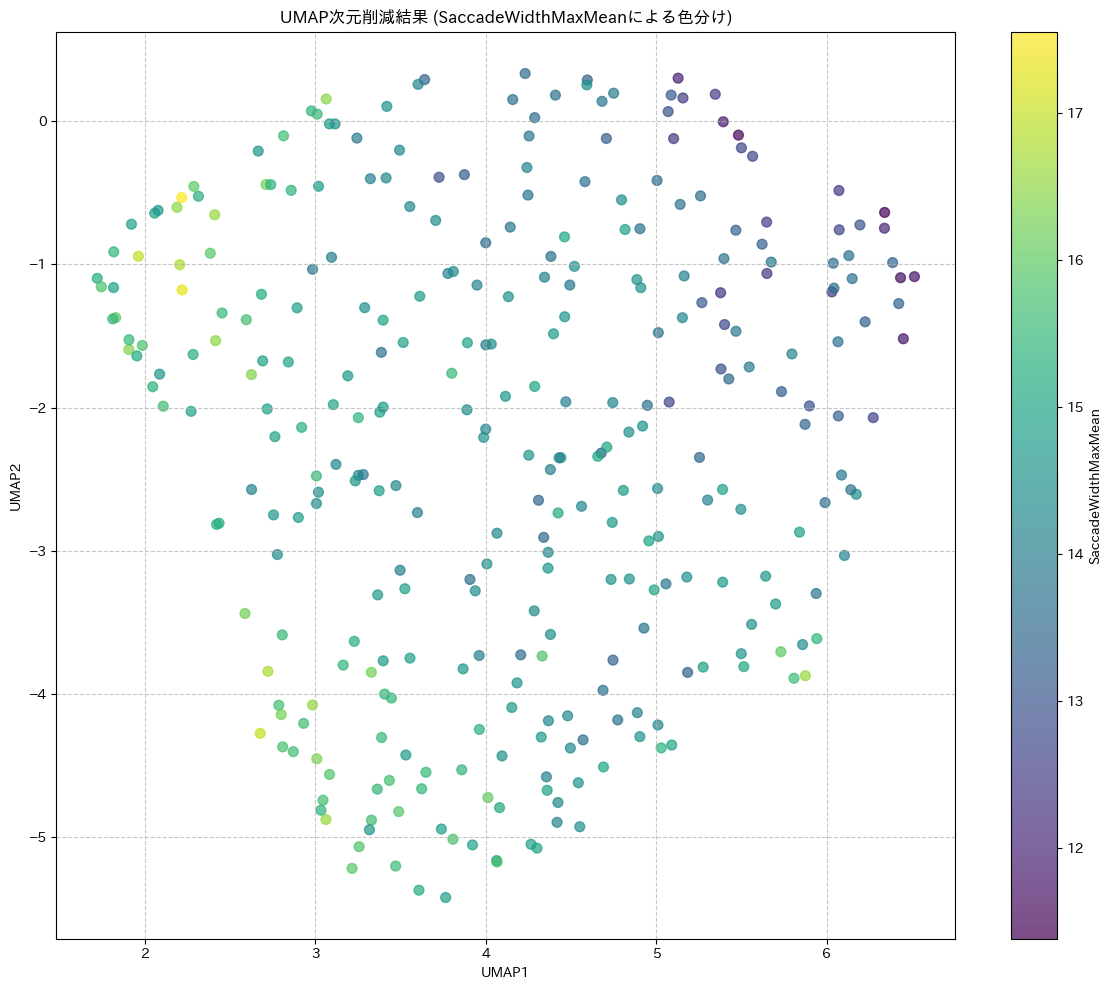

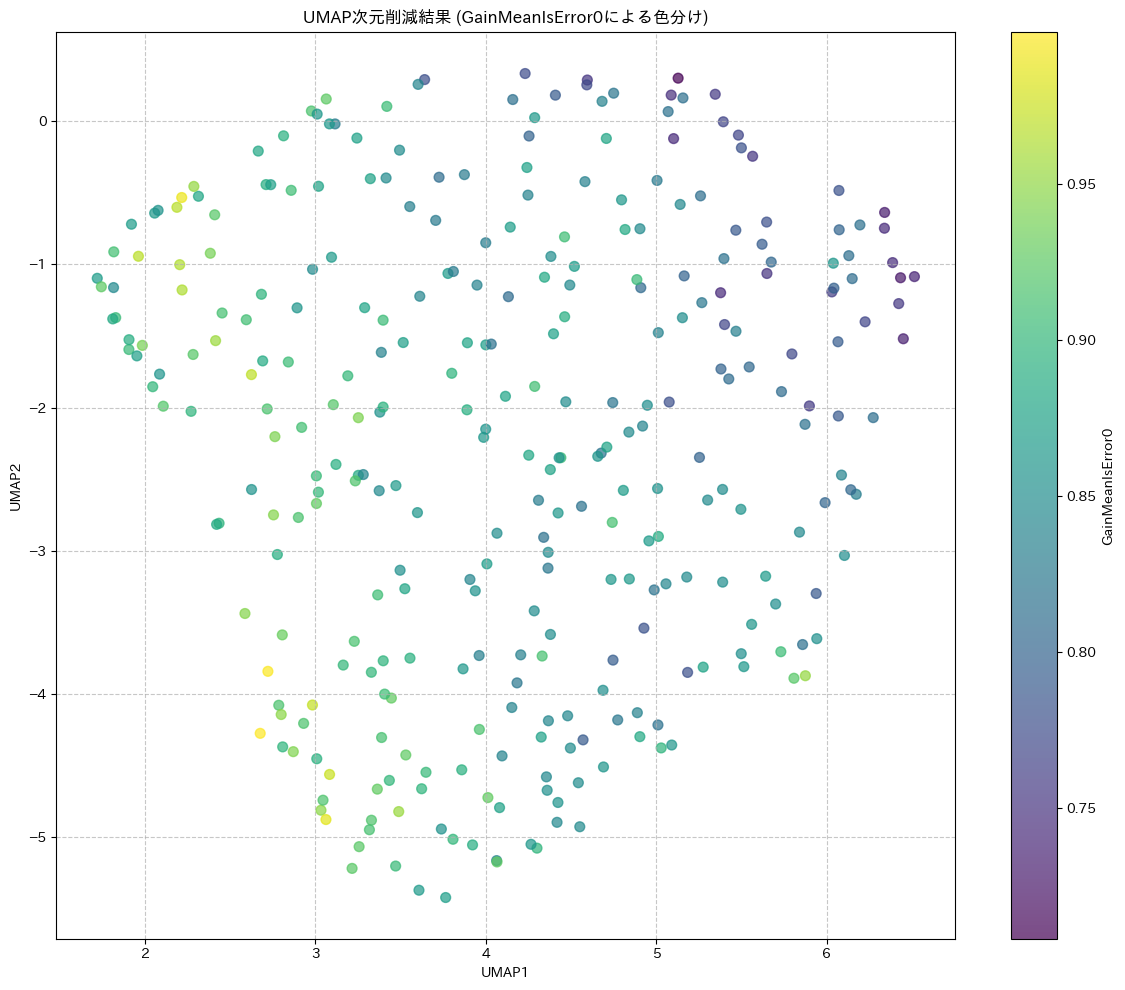

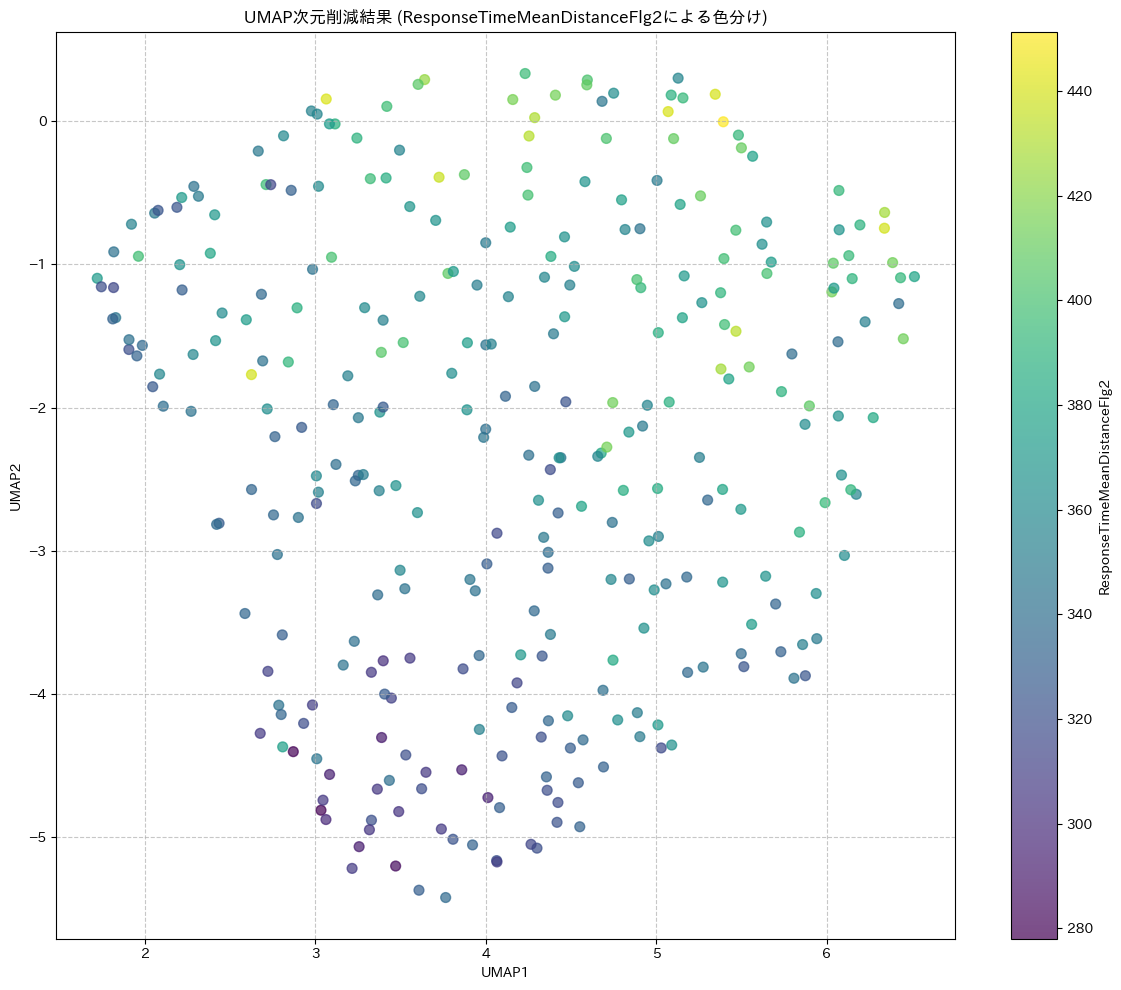

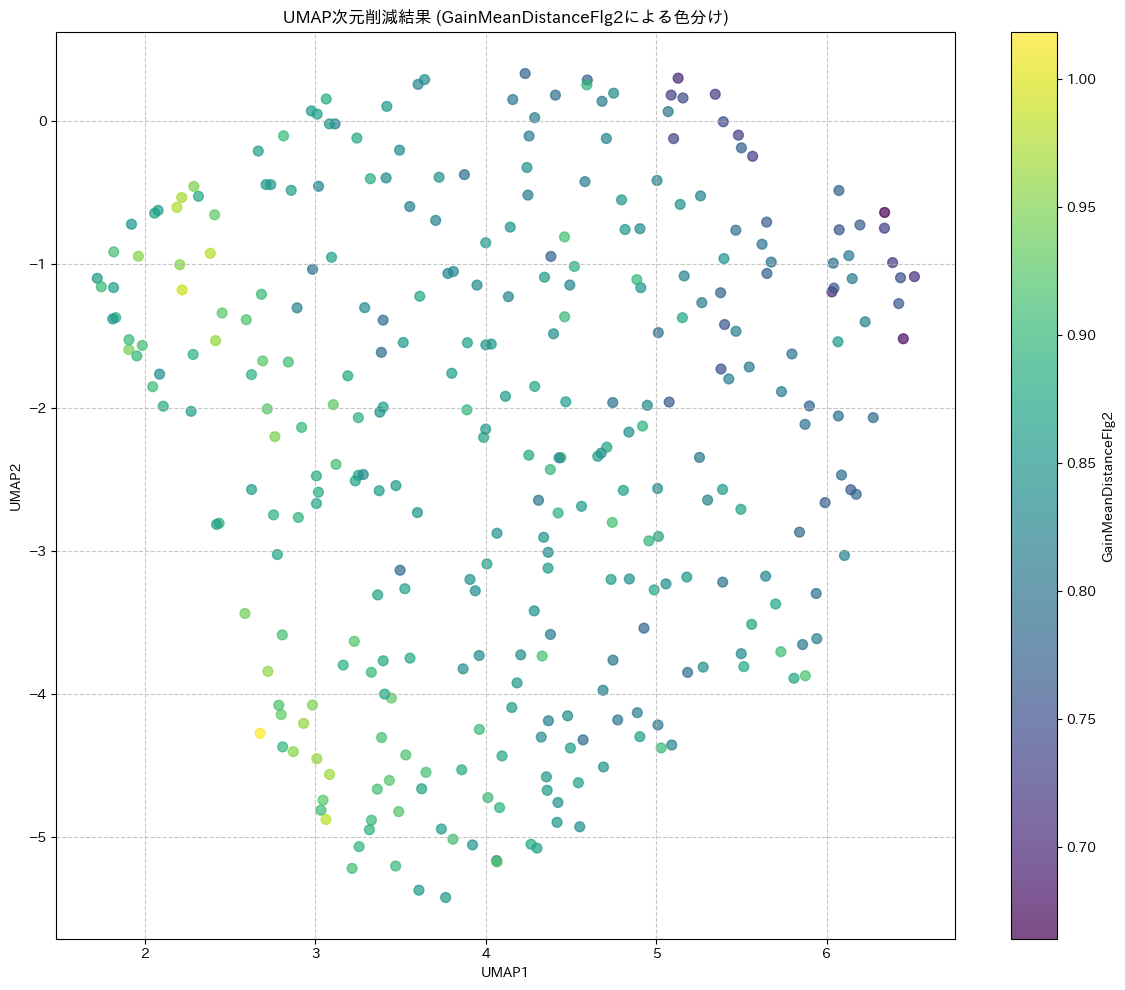

UMAP結果をG:\共有ドライブ\GAP_長寿研\user\iwamoto\視線の動きの俊敏さ\result\dr\umap_result.csvに保存しました
UMAP次元との相関係数をG:\共有ドライブ\GAP_長寿研\user\iwamoto\視線の動きの俊敏さ\result\dr\umap_feature_correlations.csvに保存しました
UMAP空間での近接点を分析中...


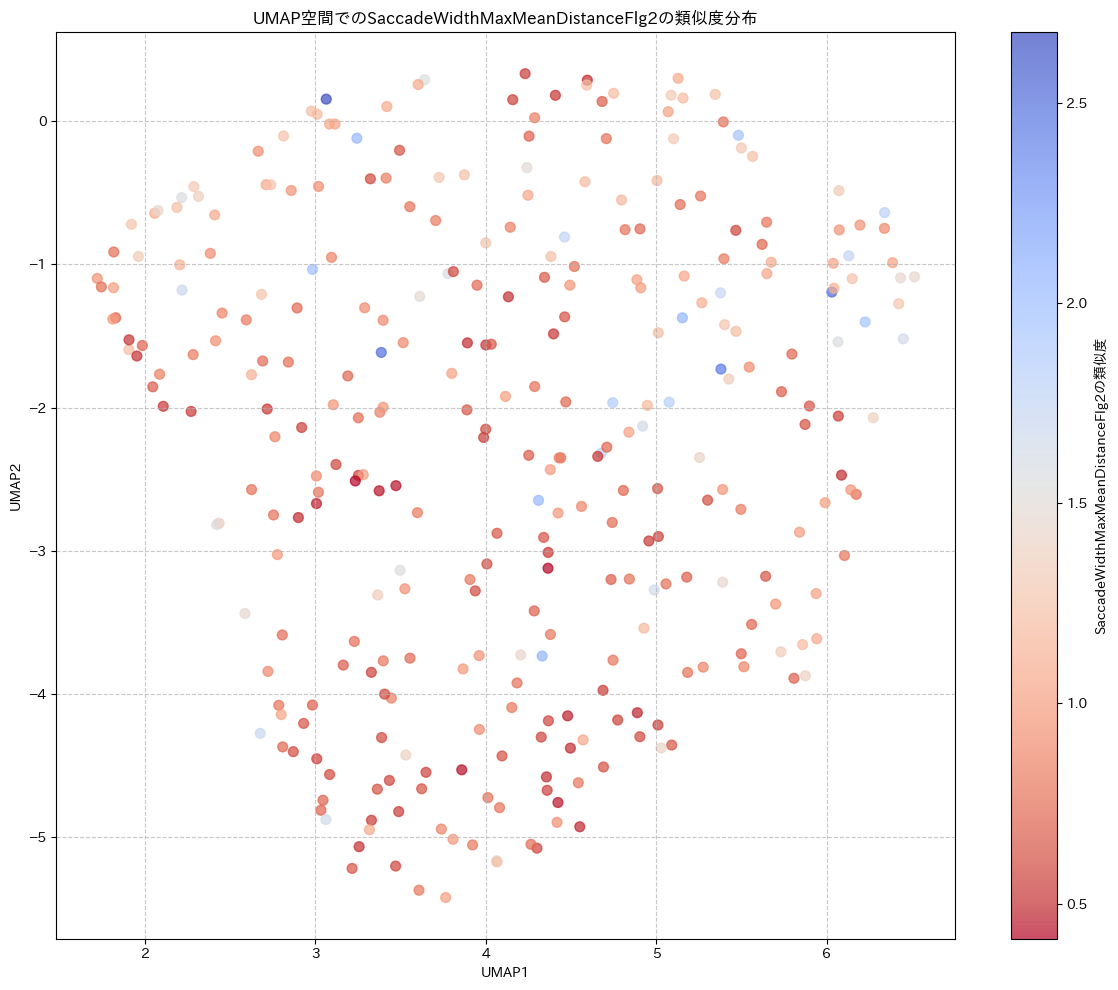

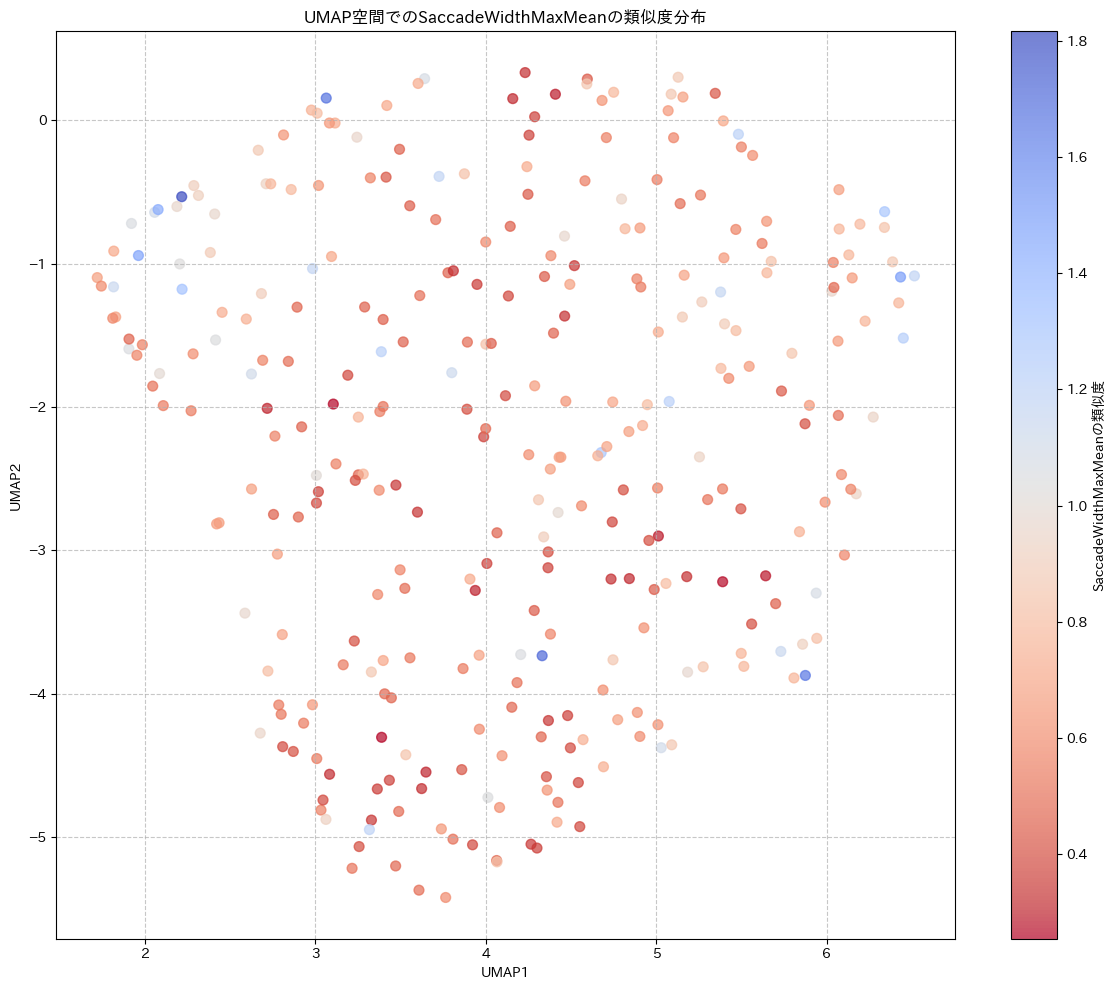

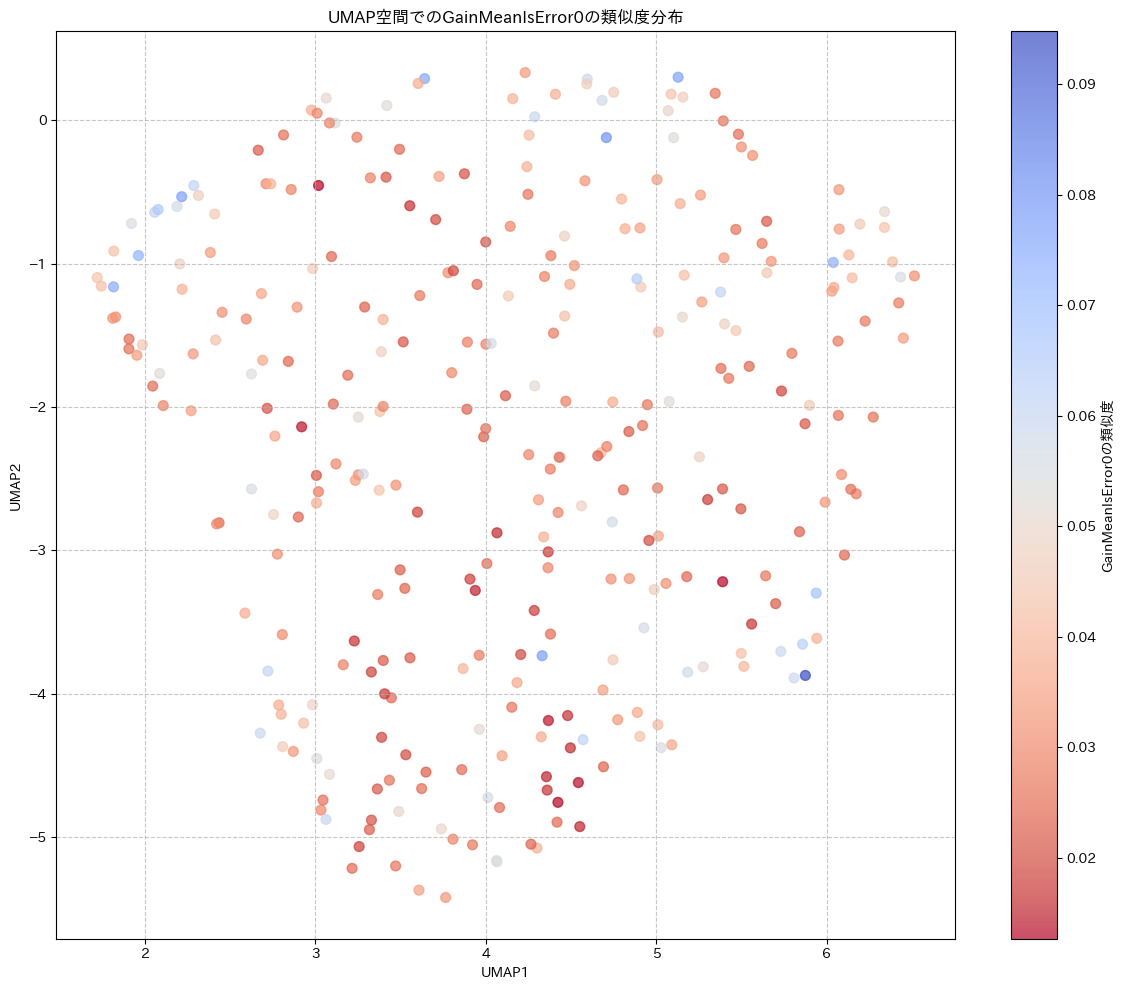

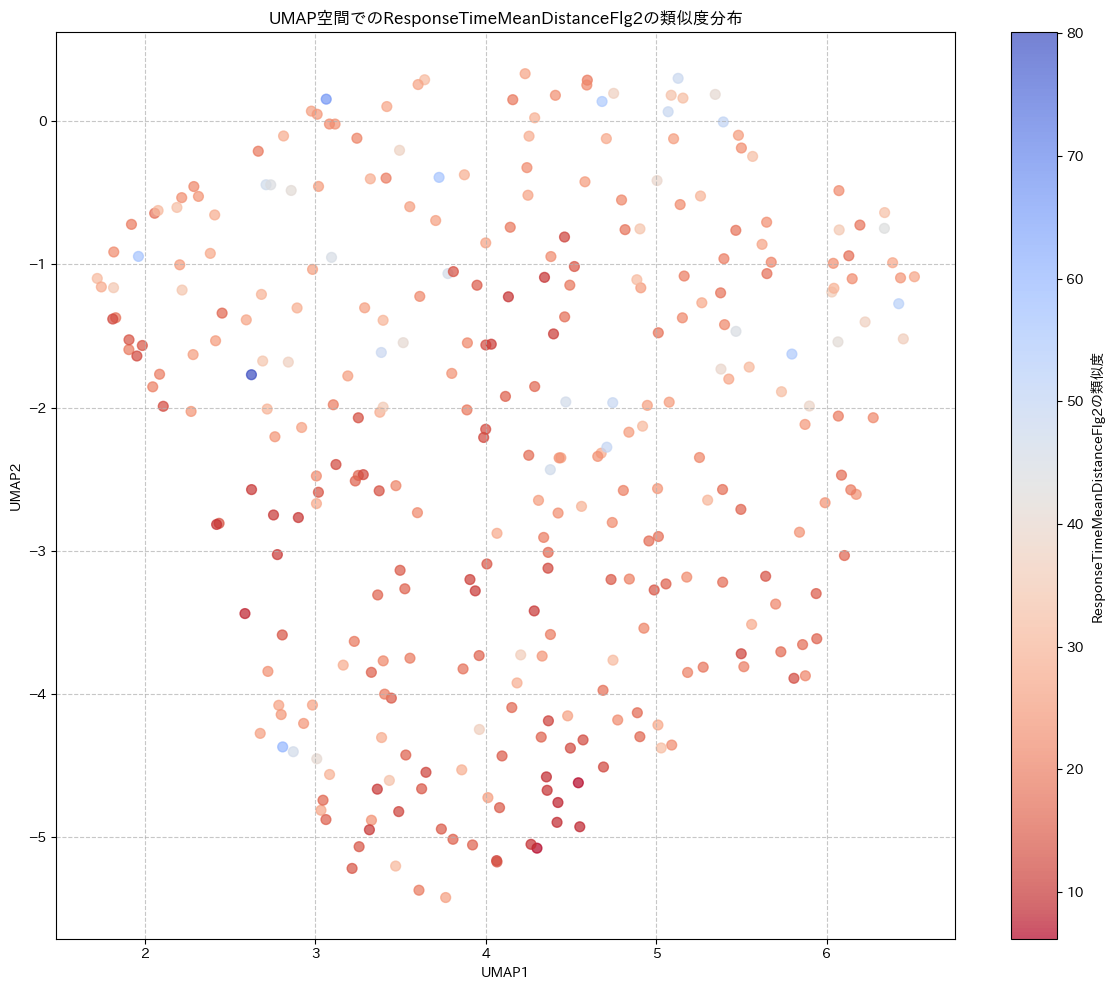

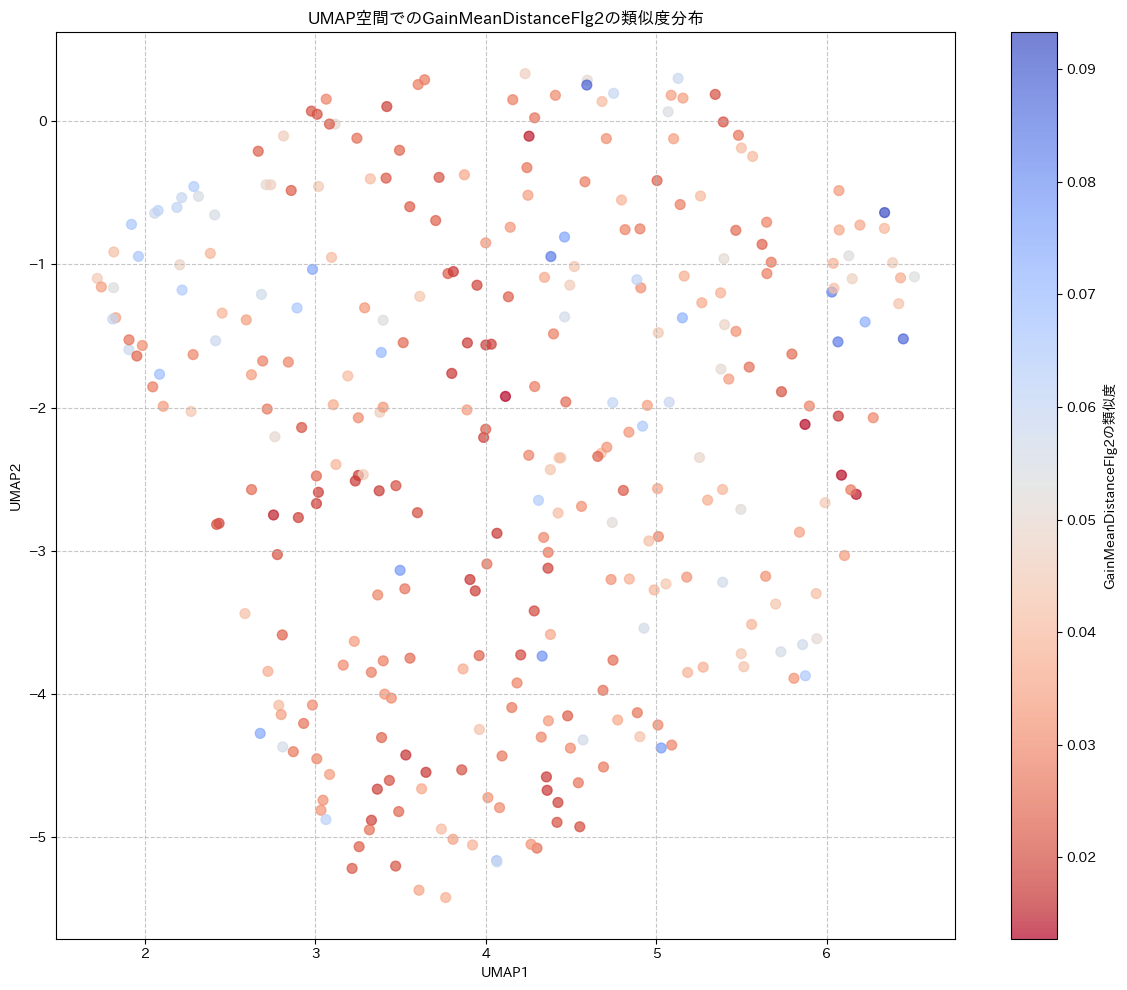

KMeansクラスタリングを実行中 (クラスタ数: 5)...


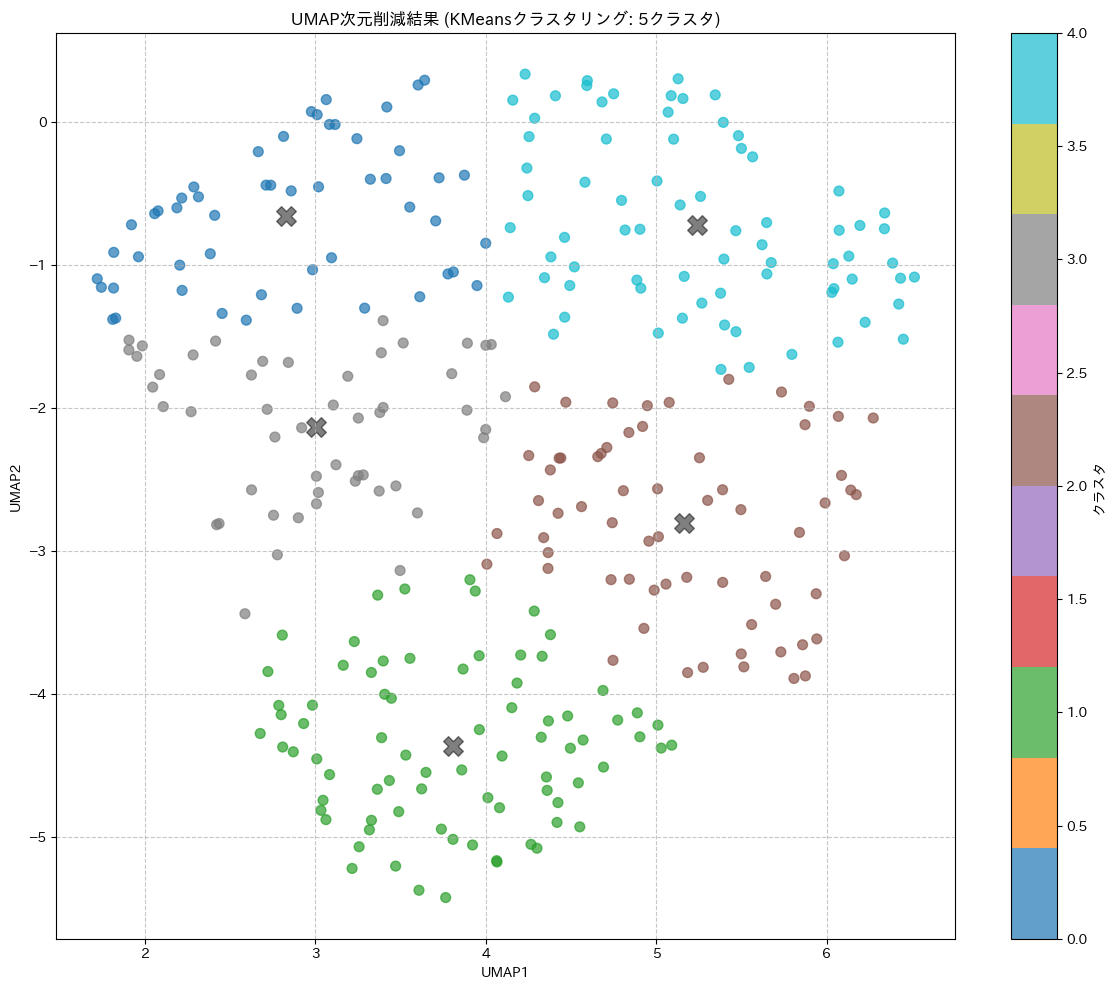

UMAPによる3次元への次元削減を実行中...
3次元UMAP次元削減が完了しました


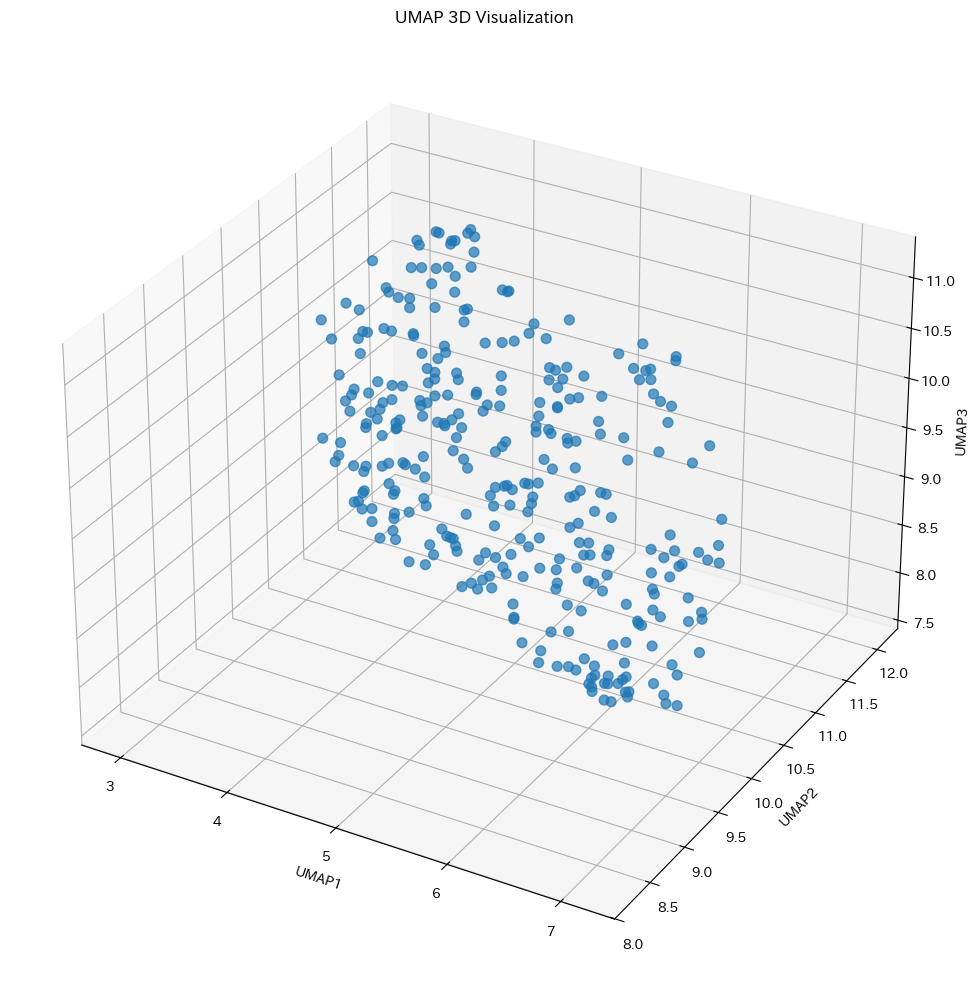

3次元UMAP結果をG:\共有ドライブ\GAP_長寿研\user\iwamoto\視線の動きの俊敏さ\result\dr\umap_3d_result.csvに保存しました
すべての処理が完了しました。


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import seaborn as sns
import os
import io
import warnings
warnings.filterwarnings('ignore')

# japanize_matplotlibが利用可能かチェック
try:
    import japanize_matplotlib
    print("日本語フォントが利用可能です")
except ImportError:
    print("日本語フォントが利用できません。必要な場合はpip install japanize_matplotlibでインストールしてください")

# ファイルパスの設定
path = "G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data"
file_path = f"{path}/S2023combined_15sec_windows_analysis_sens1_vel0_excl0s.csv"

# 結果を保存するディレクトリ
result_path = r"G:\共有ドライブ\GAP_長寿研\user\iwamoto\視線の動きの俊敏さ\result\dr"
os.makedirs(result_path, exist_ok=True)

# データ読み込み関数
def load_data(filepath, sep=','):
    try:
        # CSVファイルの読み込み
        df = pd.read_csv(filepath, sep=sep)
        print(f"CSVファイルの読み込みに成功しました。行数: {len(df)}")
        return df
    except Exception as e:
        print(f"CSVファイルの読み込みに失敗しました: {e}")
        return None

# データの前処理関数
def preprocess_data(df):
    if df is None:
        return None, None
    
    print("データのサイズ:", df.shape)
    print("カラム名の一部:", df.columns[:10], "...")  # 最初の10カラムのみ表示
    
    # 配列データを含むカラムを特定（freq, power_spectrumなど）
    string_array_columns = []
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].iloc[0], str):
            if df[col].iloc[0].startswith('[') and df[col].iloc[0].endswith(']'):
                string_array_columns.append(col)
    
    if string_array_columns:
        print(f"配列データを含むカラム ({len(string_array_columns)}個):", string_array_columns)
        df = df.drop(columns=string_array_columns)
        print(f"配列データを含むカラムを削除しました。残りのカラム数: {len(df.columns)}")
    
    # 除外するカラム
    exclude_columns = ['InspectionDateAndId', 'EyeSide', 'MoCALabel']
    
    # ターゲットカラムを特定
    target_column = None
    if 'Target' in df.columns:
        target_column = 'Target'
        print(f"ターゲットカラム 'Target' が見つかりました。")
    elif 'MoCA' in df.columns:
        target_column = 'MoCA'
        print(f"ターゲットカラム 'MoCA' が見つかりました。")
    
    # 数値型に変換できないカラムを特定して除外
    non_numeric_columns = []
    for col in df.columns:
        if col not in exclude_columns and col != target_column:
            if df[col].dtype == 'object':
                try:
                    df[col] = pd.to_numeric(df[col])
                    print(f"カラム '{col}' を数値型に変換しました。")
                except:
                    non_numeric_columns.append(col)
                    print(f"カラム '{col}' は数値型に変換できないため除外します。")
    
    # 非数値型カラムを除外
    if non_numeric_columns:
        df = df.drop(columns=non_numeric_columns)
        print(f"非数値型カラム ({len(non_numeric_columns)}個) を除外しました。")
    
    # 除外カラムのうち、データフレームに存在するものを削除
    for col in exclude_columns:
        if col in df.columns:
            df = df.drop(columns=[col])
    
    print(f"前処理後のデータサイズ: {df.shape}")
    return df, target_column

# UMAP次元削減実行関数
def perform_umap(df, target_column=None):
    # 特徴量とターゲットを分離
    if target_column and target_column in df.columns:
        X = df.drop(columns=[target_column])
        y = df[target_column]
        print(f"特徴量の数: {X.shape[1]}, ターゲットカラム: {target_column}")
    else:
        X = df
        y = None
        print(f"特徴量の数: {X.shape[1]}, ターゲットカラムなし")
    
    # NaN値の確認と処理
    nan_count = X.isna().sum().sum()
    print(f"NaN値の合計: {nan_count}")
    
    if nan_count > 0:
        # 数値型カラムに対してのみNaN値を平均値で置換
        for col in X.select_dtypes(include=[np.number]).columns:
            if X[col].isna().sum() > 0:
                X[col] = X[col].fillna(X[col].mean())
        print("NaN値を平均値で置換しました")
    
    # 特徴量のスケーリング（標準化）
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("特徴量の標準化が完了しました")
    
    # UMAPによる2次元への次元削減
    print("UMAPによる2次元への次元削減を実行中...")
    try:
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
        embedding = reducer.fit_transform(X_scaled)
        print("UMAP次元削減が完了しました")
        
        # 結果をデータフレームに格納
        result_df = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1]
        })
        
        # ターゲットカラムがある場合は追加
        if target_column and target_column in df.columns:
            result_df[target_column] = y.values
        
        return result_df, embedding, X
    
    except Exception as e:
        print(f"UMAP次元削減中にエラーが発生しました: {e}")
        return None, None, X

# 可視化関数
def visualize_umap(result_df, embedding, X, target_column=None):
    if result_df is None or embedding is None:
        print("可視化するためのデータがありません")
        return
    
    # 基本的な散布図
    plt.figure(figsize=(12, 10))
    
    # ターゲットカラムがある場合は色分け
    if target_column and target_column in result_df.columns:
        unique_targets = result_df[target_column].unique()
        
        # カテゴリが多すぎる場合はhueではなくcmapを使用
        if len(unique_targets) > 10:
            scatter = plt.scatter(
                result_df['UMAP1'], 
                result_df['UMAP2'], 
                c=result_df[target_column], 
                cmap='viridis',
                alpha=0.7,
                s=50
            )
            plt.colorbar(scatter, label=target_column)
        else:
            # カテゴリ数が少ない場合はカテゴリごとに色分け
            sns.scatterplot(
                x='UMAP1', 
                y='UMAP2', 
                hue=target_column,
                palette='tab10',
                data=result_df,
                alpha=0.7,
                s=50
            )
            plt.legend(title=target_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        # ターゲットがない場合はシンプルな散布図
        plt.scatter(
            result_df['UMAP1'], 
            result_df['UMAP2'], 
            alpha=0.7,
            s=50
        )
    
    plt.title('UMAP次元削減結果')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(result_path, 'umap_result.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # UMAPと元の特徴量の関係性を可視化するヒートマップ
    print("UMAP次元と元の特徴量との相関を計算中...")
    correlations = pd.DataFrame(index=['UMAP1', 'UMAP2'])
    
    # 各特徴量とUMAP次元の相関を計算
    for feature in X.columns:
        # UMAPの各次元と特徴量の相関を計算
        corr_umap1 = np.corrcoef(embedding[:, 0], X[feature])[0, 1]
        corr_umap2 = np.corrcoef(embedding[:, 1], X[feature])[0, 1]
        correlations[feature] = [corr_umap1, corr_umap2]
    
    # 相関値の絶対値でソートし、影響が大きい特徴量を特定
    abs_corrs = correlations.abs().mean().sort_values(ascending=False)
    n_top_features = min(80, len(X.columns))  # 特徴量が多い場合は上位90個に制限
    top_features = abs_corrs.index[:n_top_features]
    
    print(f"UMAP次元との相関が高い上位{n_top_features}個の特徴量:")
    for i, feature in enumerate(top_features[:10], 1):  # 上位10個のみ表示
        print(f"{i}. {feature}: {abs_corrs[feature]:.4f}")
    
    # 相関係数の表を作成
    correlation_table = correlations[top_features].T
    correlation_table.columns = ['UMAP1相関', 'UMAP2相関']
    correlation_table['平均絶対相関'] = abs_corrs[top_features]
    
    # 上位の特徴量のみを使ったヒートマップ
    plt.figure(figsize=(18, 8))
    sns.heatmap(
        correlations[top_features], 
        annot=True, 
        cmap='coolwarm', 
        center=0,
        fmt='.2f'
    )
    plt.title('UMAP次元と元の特徴量との相関')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(result_path, 'umap_feature_correlation.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 上位の特徴量による色分け散布図
    n_viz_features = min(5, len(top_features))  # 最大5つの特徴量を可視化
    print(f"上位{n_viz_features}個の特徴量で色分けした散布図を作成中...")
    
    for feature in top_features[:n_viz_features]:
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=X[feature],
            cmap='viridis',
            alpha=0.7,
            s=50
        )
        plt.colorbar(scatter, label=feature)
        plt.title(f'UMAP次元削減結果 ({feature}による色分け)')
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(result_path, f'umap_colored_by_{feature}.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # 結果をCSVファイルとして保存
    result_csv_path = os.path.join(result_path, 'umap_result.csv')
    result_df.to_csv(result_csv_path, index=False)
    print(f"UMAP結果を{result_csv_path}に保存しました")
    
    # 相関係数をCSVファイルとして保存
    correlation_csv_path = os.path.join(result_path, 'umap_feature_correlations.csv')
    correlation_table.to_csv(correlation_csv_path)
    print(f"UMAP次元との相関係数を{correlation_csv_path}に保存しました")

# 3次元UMAPの実行と可視化関数
def perform_umap_3d(df, target_column=None):
    if df is None:
        return None, None
    
    # 特徴量とターゲットを分離
    if target_column and target_column in df.columns:
        X = df.drop(columns=[target_column])
        y = df[target_column]
    else:
        X = df
        y = None
    
    # NaN値の処理
    for col in X.select_dtypes(include=[np.number]).columns:
        if X[col].isna().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # 特徴量のスケーリング（標準化）
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # UMAPによる3次元への次元削減
    print("UMAPによる3次元への次元削減を実行中...")
    try:
        reducer_3d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
        embedding_3d = reducer_3d.fit_transform(X_scaled)
        print("3次元UMAP次元削減が完了しました")
        
        # 結果をデータフレームに格納
        result_df_3d = pd.DataFrame({
            'UMAP1': embedding_3d[:, 0],
            'UMAP2': embedding_3d[:, 1],
            'UMAP3': embedding_3d[:, 2]
        })
        
        # ターゲットカラムがある場合は追加
        if target_column and target_column in df.columns:
            result_df_3d[target_column] = y.values
        
        # 3D散布図の作成
        from mpl_toolkits.mplot3d import Axes3D
        
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        if target_column and target_column in df.columns:
            scatter = ax.scatter(
                embedding_3d[:, 0],
                embedding_3d[:, 1],
                embedding_3d[:, 2],
                c=y,
                cmap='viridis',
                s=50,
                alpha=0.7
            )
            plt.colorbar(scatter, ax=ax, label=target_column)
        else:
            ax.scatter(
                embedding_3d[:, 0],
                embedding_3d[:, 1],
                embedding_3d[:, 2],
                s=50,
                alpha=0.7
            )
        
        ax.set_title('UMAP 3D Visualization')
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.set_zlabel('UMAP3')
        
        plt.tight_layout()
        plt.savefig(os.path.join(result_path, 'umap_3d_result.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # 結果をCSVファイルとして保存
        result_3d_csv_path = os.path.join(result_path, 'umap_3d_result.csv')
        result_df_3d.to_csv(result_3d_csv_path, index=False)
        print(f"3次元UMAP結果を{result_3d_csv_path}に保存しました")
        
        return result_df_3d, embedding_3d
    
    except Exception as e:
        print(f"3次元UMAP次元削減中にエラーが発生しました: {e}")
        return None, None

# UMAP空間での近接点の特徴分析
def analyze_nearest_neighbors(embedding, X, top_features):
    from sklearn.neighbors import NearestNeighbors
    
    print("UMAP空間での近接点を分析中...")
    
    # UMAP空間での近接点を見つける
    nn = NearestNeighbors(n_neighbors=10)
    nn.fit(embedding)
    distances, indices = nn.kneighbors(embedding)
    
    # 各点の近接点との特徴量平均差を計算
    feature_similarity = pd.DataFrame(index=range(len(embedding)), columns=top_features[:10])
    
    for i in range(len(embedding)):
        neighbors = indices[i, 1:]  # 自分自身を除く
        for feature in top_features[:10]:
            # 自分と近接点の特徴量差の平均
            feature_similarity.loc[i, feature] = np.mean(np.abs(X.iloc[i][feature] - X.iloc[neighbors][feature]))
    
    # 近接点との特徴差が小さい＝クラスタ内で均一な特徴
    # 近接点との特徴差が大きい＝クラスタの境界に位置する可能性
    for feature in top_features[:5]:
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=feature_similarity[feature],
            cmap='coolwarm_r',  # 逆にして、差が小さい（類似度が高い）ほど暖色に
            alpha=0.7,
            s=50
        )
        plt.colorbar(scatter, label=f'{feature}の類似度')
        plt.title(f'UMAP空間での{feature}の類似度分布')
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(result_path, f'umap_similarity_{feature}.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    return feature_similarity

# クラスタリング分析の関数
def perform_clustering(embedding, n_clusters=5):
    from sklearn.cluster import KMeans
    
    print(f"KMeansクラスタリングを実行中 (クラスタ数: {n_clusters})...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embedding)
    
    # クラスタごとの散布図
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=clusters,
        cmap='tab10',
        alpha=0.7,
        s=50
    )
    
    # クラスタの中心を表示
    centers = kmeans.cluster_centers_
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        c='black',
        s=200,
        alpha=0.5,
        marker='X'
    )
    
    plt.colorbar(scatter, label='クラスタ')
    plt.title(f'UMAP次元削減結果 (KMeansクラスタリング: {n_clusters}クラスタ)')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(result_path, f'umap_kmeans_clusters_{n_clusters}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return clusters

# メイン処理
def main():
    # データ読み込み
    df = load_data(file_path)
    
    if df is None:
        print("データの読み込みに失敗しました。処理を終了します。")
        return
    
    # データ前処理
    df_cleaned, target_column = preprocess_data(df)
    
    if df_cleaned is None or df_cleaned.empty:
        print("前処理後のデータが空です。処理を終了します。")
        return
    
    # UMAP次元削減
    result_df, embedding, X = perform_umap(df_cleaned, target_column)
    
    if result_df is None or embedding is None:
        print("UMAP次元削減に失敗しました。処理を終了します。")
        return
    
    # 結果の可視化
    visualize_umap(result_df, embedding, X, target_column)
    
    # 上位特徴量の抽出
    correlations = pd.DataFrame(index=['UMAP1', 'UMAP2'])
    for feature in X.columns:
        corr_umap1 = np.corrcoef(embedding[:, 0], X[feature])[0, 1]
        corr_umap2 = np.corrcoef(embedding[:, 1], X[feature])[0, 1]
        correlations[feature] = [corr_umap1, corr_umap2]
    
    abs_corrs = correlations.abs().mean().sort_values(ascending=False)
    top_features = abs_corrs.index[:90]  # 上位90個の特徴量を選択
    
    # 近接点分析
    feature_similarity = analyze_nearest_neighbors(embedding, X, top_features)
    
    # クラスタリング分析
    clusters = perform_clustering(embedding, n_clusters=5)
    
    # 3次元UMAP
    result_df_3d, embedding_3d = perform_umap_3d(df_cleaned, target_column)
    
    print("すべての処理が完了しました。")

if __name__ == "__main__":
    main()